In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pymc
%matplotlib inline

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv('data7a.csv')

In [3]:
data.y.describe()

count    100.000000
mean       4.030000
std        3.150934
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max        8.000000
Name: y, dtype: float64

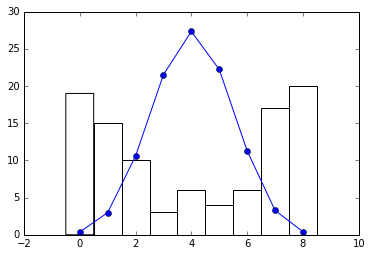

In [4]:
plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white')
plt.plot(np.linspace(0,8,9),scipy.stats.binom.pmf(np.linspace(0,8,9),8,0.504)*100,'o-')
plt.show()

In [5]:
Y = data.y
N = len(Y)
s = pymc.Uniform(name='s',lower=0,upper = 1.0e+4,value=0.01)
b = pymc.Normal(name='b', mu=0.0, tau=1.0e+2)

r = [pymc.Normal(name='r_{0}'.format(i),mu=0,tau=s**(-2)) for i in range(N)]
p = pymc.Lambda('p',lambda r = r,b=b:pymc.invlogit(b+r))

obs = pymc.Binomial(name='obs',n=8,p=p,value=Y,observed=True)
model = pymc.Model([b,s,obs])

In [6]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 207.5 sec

Plotting b


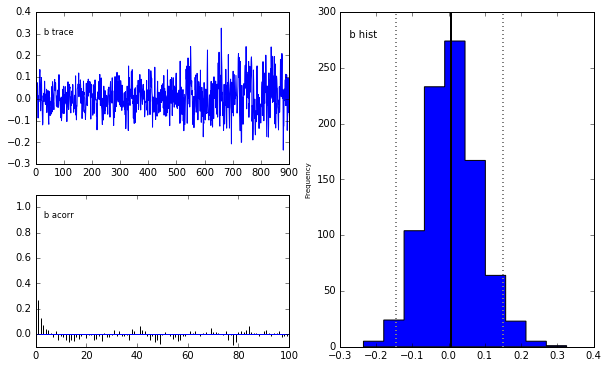

In [7]:
pymc.Matplot.plot(mcmc.trace('b'),common_scale=False)

Plotting s


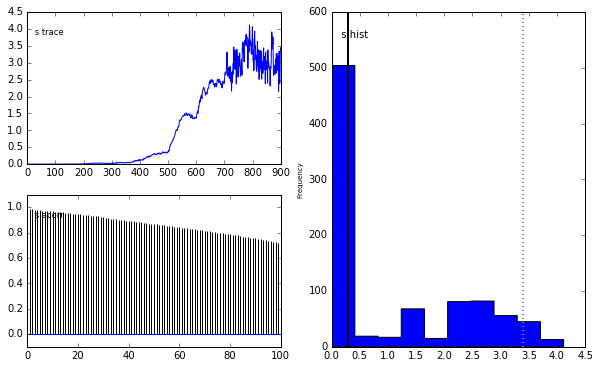

In [10]:
pymc.Matplot.plot(mcmc.trace('s'),common_scale=False)

Plotting r_0


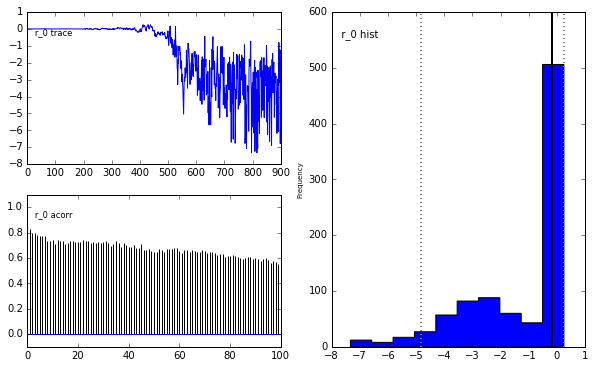

In [14]:
pymc.Matplot.plot(mcmc.trace('r_0'),common_scale=False)

In [29]:
left = 600

L = []
b_= np.mean(mcmc.trace('b')[left:])

for i in range(N):
    ri = np.mean(mcmc.trace('r_{0}'.format(i))[left:])
    L.append(pymc.binomial_expval(n=8,p=pymc.invlogit(b_+ri)))

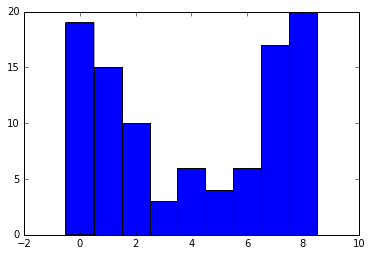

In [45]:
n_b, bins_b, pathces_b = plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white',label='before')
n_a, bins_a, pathces_a = plt.hist(L,bins=np.linspace(-0.5,8.5,10),color='blue',label='after')
plt.show()

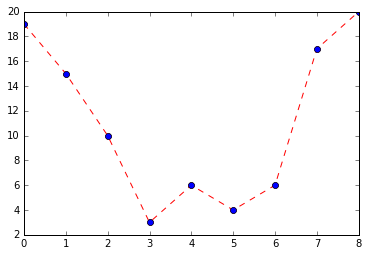

In [53]:
plt.plot(np.linspace(0,8,9),n_b,'ro--',label='before')
plt.plot(np.linspace(0,8,9),n_a,'bo',label='after')

In [48]:
np.linspace(0,8,9)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

(array([  6.,  11.,  35.,  52.,  70.,  64.,  31.,  20.,   9.,   2.]),
 array([-1.49634284, -1.06278935, -0.62923586, -0.19568237,  0.23787112,
         0.67142461,  1.1049781 ,  1.53853159,  1.97208508,  2.40563857,
         2.83919206]),
 <a list of 10 Patch objects>)

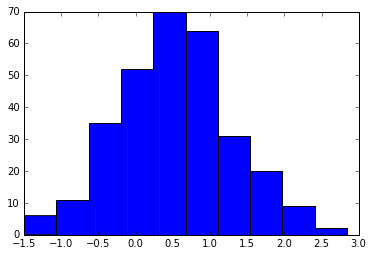

In [56]:
plt.hist(mcmc.trace('r_50')[left:])